In [8]:
import altair as alt
from bs4 import BeautifulSoup
from vega_datasets import data
import geopandas
import json
import shapely
import re
from matplotlib import pyplot as plt
%matplotlib inline

# Extract locations from XML data

In [9]:
portraitRaw = open('../portrait.xml').read()
portraitSoup = BeautifulSoup(portraitRaw)
geos = portraitSoup.find_all('geo')

In [11]:
geotext = [item.text for item in geos]

In [12]:
lineNos = [int(item.parent.parent.find_previous('lb').attrs['n']) for item in geos]

In [13]:
points = [shapely.geometry.point.Point([float(x) for x in pt.strip().split()[-1::-1]]) for pt in geotext]

In [14]:
def clean(text): 
    return re.sub('\s+', ' ', text.strip().replace('\n', ' '))

In [15]:
names = [clean(item.parent.parent.find('placename').text.strip()) for item in geos]

In [16]:
gdf = geopandas.GeoDataFrame({'name': names, 'lineNo': lineNos, 'geometry': points})

In [17]:
gdf.head()

,name,lineNo,geometry
0,Leicester Abbey,10112,POINT (-1.132563 52.640379)
1,Leicester Abbey,10116,POINT (-1.132563 52.640379)
2,Mozambique Channel,10132,POINT (41.280858 -18.615949)
3,the longest river in America,10133,POINT (-90.199404 38.627003)
4,Wicklow Hotel,10154,POINT (-6.260651 53.342872)


# Use Natural Earth Land Vectors

From: https://www.naturalearthdata.com/downloads/50m-physical-vectors/50m-land/

In [18]:
gdf2 = geopandas.read_file('mapData/ne_50m_land.shp')

In [19]:
gdf.head()

,name,lineNo,geometry
0,Leicester Abbey,10112,POINT (-1.132563 52.640379)
1,Leicester Abbey,10116,POINT (-1.132563 52.640379)
2,Mozambique Channel,10132,POINT (41.280858 -18.615949)
3,the longest river in America,10133,POINT (-90.199404 38.627003)
4,Wicklow Hotel,10154,POINT (-6.260651 53.342872)


In [20]:
gdf2.head()

,scalerank,featurecla,min_zoom,geometry
0,0,Land,1.5,"POLYGON ((179.99921875 -16.16855468750001, 179..."
1,0,Land,4.0,"POLYGON ((177.2341796875 -17.14707031250001, 1..."
2,0,Land,4.0,"POLYGON ((127.37265625 0.7913085937499886, 127..."
3,0,Land,3.0,POLYGON ((-81.33481445312499 24.65048828124999...
4,0,Land,4.0,"POLYGON ((-80.82939453124999 24.803662109375, ..."


# Apply Mercator projection

In [21]:
gdf.crs = {'init': 'epsg:4326'}
# gdf.crs = {'init': 'epsg:27700'}
# gdf2.crs = {'init': 'epsg:27700'}

In [33]:
gdf = gdf.to_crs({'init': 'epsg:4326'}) # Mercator
gdf2 = gdf2.to_crs({'init': 'epsg:4326'}) # Mercator
# gdf = gdf.to_crs({'init': 'epsg:27700'}) # Britain
# gdf2 = gdf2.to_crs({'init': 'epsg:27700'}) # Britain
# gdf = gdf.to_crs({'init': 'epsg:2163'}) # Britain
# gdf2 = gdf2.to_crs({'init': 'epsg:2163'}) # Britain

In [34]:
gdf.crs, gdf2.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'})

In [97]:
# Simple Method. Not working
ax = gdf2[-12:1,50:60].plot()
gdf[-12:1,50:60].plot(ax=ax, color='red', markersize=10)

TypeError: '(slice(-12, 1, None), slice(50, 60, None))' is an invalid key

# Convert line numbers to percentages

In [63]:
def lineToPercent(lineNo): 
    """ Convert the line number to a percentage in the narrative time of the novel,
    i.e., 0% is the beginning of the novel, 100% is the end. """
    maxLines = {1: 1848, 2: 1458, 3: 1584, 4: 922, 5: 2794}
    totalLines = sum(maxLines.values())
    chap = int(str(lineNo)[0])
    linesIntoChap = lineNo - (chap * 10000)
    preceedingLines = sum([maxLines[i] for i in range(1, chap)])
    return (preceedingLines + linesIntoChap) / totalLines

In [64]:
gdf['percentNarrative'] = gdf['lineNo'].apply(lineToPercent)

In [98]:
gdf.head()

,name,lineNo,geometry,percentNarrative
0,Leicester Abbey,10112,POINT (-1.132563000000026 52.640379),0.013014
1,Leicester Abbey,10116,POINT (-1.132563000000026 52.640379),0.013479
2,Mozambique Channel,10132,POINT (41.28085799999999 -18.615949),0.015338
3,the longest river in America,10133,POINT (-90.199404 38.62700300000001),0.015454
4,Wicklow Hotel,10154,POINT (-6.260650999999997 53.34287200000001),0.017894


# Plot

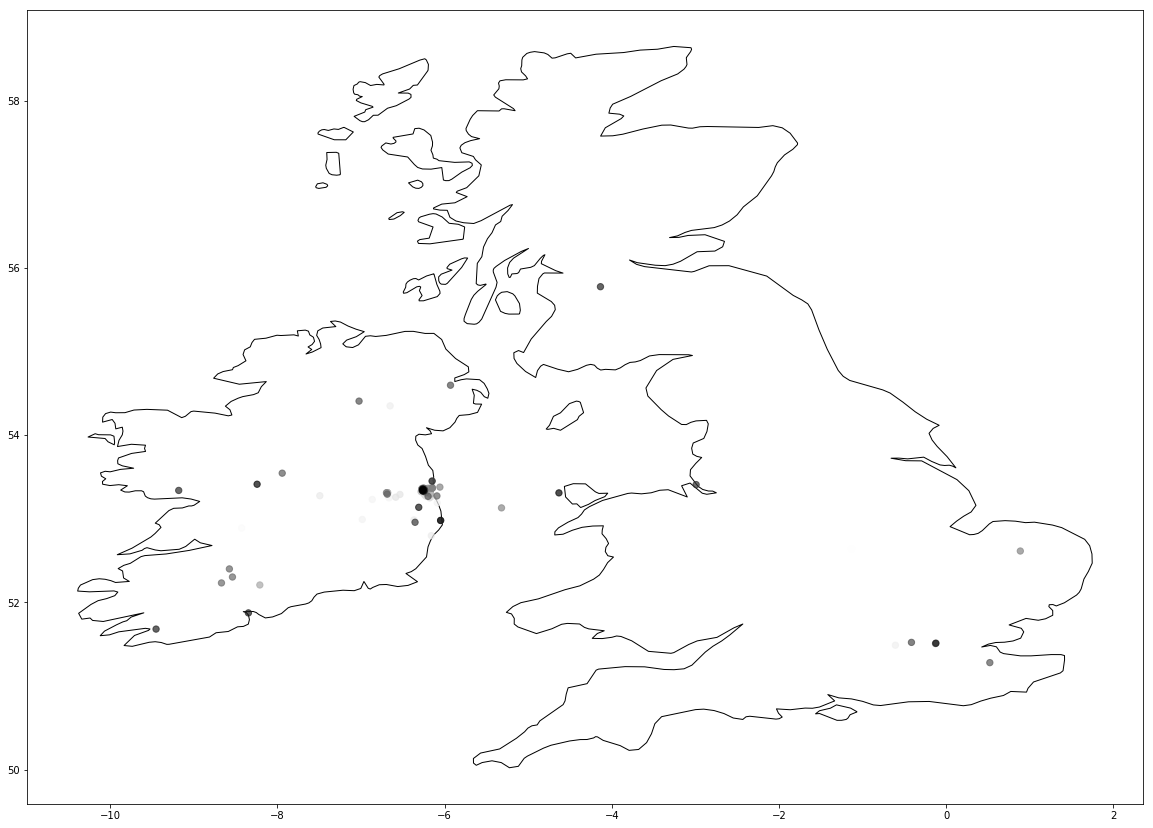

In [129]:
# Setting the figsize width here (20) seems to take effect,
# but not setting the figsize height (40). 
fig, ax = plt.subplots(figsize=(20,40))

# Slice so that it's only showing the British Isles
gdf2.cx[-11:1,50:58].plot(ax=ax, color='white', edgecolor='black')
gdf.cx[-11:1,50:58].plot(ax=ax, marker='o', c=(gdf.percentNarrative * 256), cmap='Greys', markersize=40, alpha=0.7)

# Try this again with Altair? 

In [86]:
# Write base map to geojson
open('britain.geojson', 'w').write(gdf2.cx[-12:1,50:59].to_json())

48456

In [87]:
# Write points to geojson
open('portrait.geojson', 'w').write(gdf.to_json())

29517

In [130]:
# Plot base map
base = alt.Chart('./britain.geojson').mark_geoshape(
    fill='white',
    stroke='black'
).properties(
    width=300,
    height=180
)

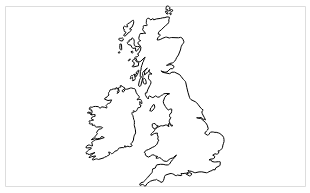

In [131]:
base

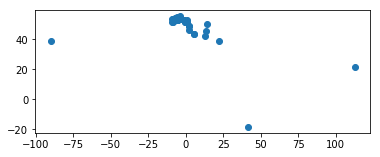

In [132]:
geopandas.read_file('portrait.geojson').plot()

In [133]:
# Plot points. Not sure why this won't work.
points = alt.Chart('./portrait.geojson').mark_circle().encode(
    latitude='latitude', longitude='longitude')

In [134]:
points = geopandas.read_file('portrait.geojson')

In [136]:
alt.Chart(points).mark_circle()

TypeError: Object of type Point is not JSON serializable

Chart({
  data:       id                                    name  lineNo  percentNarrative  \
  0      0                         Leicester Abbey   10112          0.013014   
  1      1                         Leicester Abbey   10116          0.013479   
  2      2                      Mozambique Channel   10132          0.015338   
  3      3            the longest river in America   10133          0.015454   
  4      4                           Wicklow Hotel   10154          0.017894   
  5      5                                  Dalkey   10228          0.026493   
  6      6                                Tullabeg   10243          0.028236   
  7      7                  Clongowes Wood College   10302          0.035092   
  8      8                                 Sallins   10303          0.035208   
  9      9                               Clongowes   10313          0.036370   
  10    10                                   Clane   10386          0.044852   
  11    11                